# First some definitions
Here we define the functions that find the correct path for the campaign data.

Variable names change for different campaigns so you also want to introduce dictionaries that translate variable names.
Hopefully coordinates such as range and time will not have different names in future campaigns, otherwise, more effort.

Some campaigns have variables spread around (tripex has skweness in a different location), you need a separate function for that.

This script focuses on variables that are common across campaigns (skweness is available for tripex only at Ka band, so we do not care about skweness at X and W band for tripex-pol). But in principle you can extend to campaign-specific variables: the concatenation will simply ignore the missing data

TODO: preprocess range variable to make it altitude msl, different campaigns might have the reference radar at different locations

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
from os import path

# some basics 

tripex_date_start = datetime(2015, 11, 11)
tripex_date_end = datetime(2016, 1, 4, 23, 59, 59)

tripexpol_date_start = datetime(2018, 11, 1)
tripexpol_date_end = datetime(2019, 2, 20, 23, 59, 59)

root_tripex = '/data/optimice/tripex/'
root_tripex_pol = '/data/obs/campaigns/tripex-pol/processed/'
root_pluvio = '/data/data_hatpro/jue/data/pluvio/netcdf/'

# Translate common variable names to campaign specific
tripex_vars = {'Z10':'dbz_x', 'Z35':'dbz_ka', 'Z94':'dbz_w', # reflectivity
               'time':'time', 'range':'range', # dimensions
               'T':'ta', 'P':'pa', 'RH':'hur', # thermodynamics
               'W10':'sw_x', 'W35':'sw_ka', 'W94':'sw_x', # spectral width
               'V10':'rv_x', 'V35':'rv_ka', 'V94':'rv_w', # mean doppler velocity
               'quality_x':'quality_flag_offset_w', 'quality_w':'quality_flag_offset_w',
               'S35':'sk', # skweness
               'RR':'r_accum_NRT' # rain rate from pluvio needs processing
              }
tripex_pol_vars = {'Z10':'X_DBZ_H', 'Z35':'Ka_DBZ_H', 'Z94':'W_DBZ_H', # reflectivity
                   'time':'time', 'range':'range', # dimensions
                   'T':'ta', 'P':'pa', 'RH':'hur', # thermodynamics
                   'W10':'X_WIDTH_H', 'W35':'Ka_WIDTH_H', 'W94':'W_WIDTH_H', # spectral width
                   'V10':'X_VEL_H', 'V35':'Ka_VEL_H', 'V94':'W_VEL_H', # mean doppler velocity
                   'quality_x':'quality_flag_offset_w', 'quality_w':'quality_flag_offset_w',
                   'S35':'Ka_SK_H', #skweness
                   'RR':'r_accum_NRT' # rain rate from pluvio needs processing
                  }                 
available_vars = [z for z in tripex_vars.keys()]

# Pluvio files are always loaded
def pluvio_filepath(date):
    dtstr = date.strftime('%Y%m%d')
    if date in pd.date_range(tripex_date_start, tripex_date_end):
        return root_pluvio + dtstr[2:-2] + '/pluvio2_jue_' + dtstr + '.nc'
    elif date in pd.date_range(tripexpol_date_start, tripexpol_date_end):
        return root_pluvio + dtstr[2:-2] + '/pluvio2_jue_' + dtstr + '.nc'
    else:
        return 'NOT_EXISTING_PATH...hopefully...otherwise,we,are,screwed'


def tripex_filepath(date):
    dtstr = date.strftime('%Y%m%d')
    return root_tripex + 'tripex_level_02_X_pol/tripex_joy_tricr00_l2_any_v00_' + dtstr + '000000.nc'
           

# Would be nice to add skweness to main tripex.nc files so we have unique resource
def tripex_sk_filepath(date):
    dtstr = date.strftime('%Y%m%d')
    return root_tripex + 'skewness/resampled/' + dtstr + '_sk_joyrad35.nc'


def tripol_filepath(date):
    dtstr = date.strftime('%Y%m%d')
    return root_tripex_pol + 'tripex_pol_level_2/' + dtstr + '_tripex_pol_3fr_L2_mom.nc'


print('Available vars in the library')
print(available_vars, '\n')


########################################################################################################
# Functions that might come handy later
########################################################################################################

# Define and efficient function that does running mean along one axis of a 2D array
def running_mean_2d(xx, N, minN=0, weights=None):
    if weights is None:
        weights = xx/xx
    xx = xx*weights
    add = int((N - (N & 1))/2)
    addition = np.zeros([xx.shape[0], add])*np.nan
    x = np.concatenate([addition, xx, addition], axis=1)
    w = np.concatenate([addition, weights, addition], axis=1)
    csumnan = np.cumsum((~np.isfinite(np.insert(x, 0, 0, axis=1))).astype(int),
                        axis=1)
    nannum = csumnan[:, N:] - csumnan[:, :-N]
    mask = ((N-nannum) >= minN)
    Filter = mask.astype(float)
    Filter[~mask] = np.nan
    csum = np.nancumsum(np.insert(x, 0, 0, axis=1), axis=1)
    wsum = np.nancumsum(np.insert(w, 0, 0, axis=1), axis=1)
    return Filter * (csum[:, N:] - csum[:, :-N]) / (wsum[:, N:] - wsum[:, :-N])

def Bd(x): # return linear if dB are given
    return 10.0**(0.1*x)

def dB(x): # return dB if linear are given
    return 10.0*np.log10(x)

Available vars in the library
['range', 'Z94', 'V10', 'V94', 'T', 'Z35', 'W35', 'RR', 'Z10', 'V35', 'W94', 'W10', 'quality_w', 'time', 'RH', 'quality_x', 'S35', 'P'] 



# User defined 
Edit this section putting your time frame that might span across multiple campaigns

In [2]:
available_vars

['range',
 'Z94',
 'V10',
 'V94',
 'T',
 'Z35',
 'W35',
 'RR',
 'Z10',
 'V35',
 'W94',
 'W10',
 'quality_w',
 'time',
 'RH',
 'quality_x',
 'S35',
 'P']

In [3]:
# time span of statistics

dt0 = datetime(2015, 11, 11)
dt1 = datetime(2015, 11, 12)

dt0 = datetime(2015, 12, 13)
dt1 = datetime(2015, 12, 14)

#dt0 = datetime(2019, 1, 11)
#dt1 = datetime(2019, 2, 20)

# which variables do you want? make a list from the available
#variables = available_vars
variables = ['Z10', 'Z35', 'Z94', 'V10', 'V35', 'V94', 'T']

# Rainrate from Pluvio averaged over how many minutes?
accMins = 5

# Moving window wighted average (in minutes) for mean Doppler velocities to compensate for waves
# Leave an empty list if you do not want averages
# The average will appear for every frequency as a new variable name V{freq}m{avgV}
avgV = [5, 20] # here we average over 5 and 20 minutes

## back to code

In [4]:
%%time

# always include dimensions in the list of variables to keep
variables = list(set(variables) | set(['range', 'time']))

# List of files to be loaded
tripex_files = [tripex_filepath(dt) for dt in pd.date_range(dt0, dt1) if path.exists(tripex_filepath(dt))]
tripsk_files = [tripex_sk_filepath(dt) for dt in pd.date_range(dt0, dt1) if path.exists(tripex_sk_filepath(dt))]
tripol_files = [tripol_filepath(dt) for dt in pd.date_range(dt0, dt1) if path.exists(tripol_filepath(dt))]
pluvio_files = [pluvio_filepath(dt) for dt in pd.date_range(dt0, dt1) if path.exists(pluvio_filepath(dt))]

# Function to open pluvio files and resample them on the 4s frequency of the tripex files
def open_resample_pluvio(dt_start, dt_end):
    pluvio_files = [pluvio_filepath(dt) for dt in pd.date_range(dt_start, dt_end) if path.exists(pluvio_filepath(dt))]
    if len(pluvio_files):
        save_vars = ['time', 'r_accum_NRT']
        x = xr.open_dataset(pluvio_files[0])
        varlist = list(x.variables)
        drops = [v for v in varlist if v not in save_vars]
        pluvio = xr.open_mfdataset(pluvio_files, concat_dim='dim',
                                   data_vars='minimal',
                                   drop_variables=drops).rename({'dim':'time'}).set_coords('time')
        pluvio = pluvio.loc[{'time':~pluvio.time.isnull()}] # eliminate missing times
        
        ############################################################
        # Resampling is very slow on this version of xarray (0.10) #
        ############################################################
        # Let's try old school pandas
        PLUVIO = pd.DataFrame(data=pluvio.r_accum_NRT.to_masked_array(),
                              index=pluvio.time.to_masked_array(),
                              columns=['RR'])
        PLUVIO = PLUVIO.resample(str(accMins)+'min').apply(np.nansum)*60/accMins # prbably better to do resampling and rolling
        PLUVIO = PLUVIO.resample('4s').nearest()
        PLUVIO.index.name='time'
        
        return xr.Dataset.from_dataframe(PLUVIO)
    return None


def generate_preprocess(translate):
    '''
    This is where dataset preprocess happens.
    I am still not sure if it is faster done like this or outside using lazy evaluation...
    '''
    def preprocess(ds):
        # First I find convenient to rename the variables early, so I do not have to deal with translations
        ds = ds.rename({i:v for (v,i) in translate.items() if i in ds.variables})
        # Second, it is very important to reorder the dimensions
        ds = ds.transpose('range', 'time') # this is robust with respect of the order used in the files
        if avgV: # perform moving window average for velocities
            Vvars = [v for v in ['V10', 'V35', 'V94'] if v in ds.variables]
            for m in avgV:
                steps = int(m*60/4) # I am always considering 4 seconds resampling
                steps = steps if steps % 2 else steps-1 # ensure it is odd number
                valid_steps = int(steps/5) # kind of arbitrary
                for v in Vvars:
                    ds[v+'m'+str(m)] = ds[v]*0.0 + running_mean_2d(ds[v], steps, valid_steps,
                                                                   Bd(ds['Z'+v[1:]]))
        return ds
    return preprocess


##############################################################################################################
# OPEN TRIPEX DATA 
##############################################################################################################
if len(tripex_files): # open only if requested
    # open tripex
    save_vars = [tripex_vars[v] for v in variables]
    x = xr.open_dataset(tripex_files[0])
    varlist = list(x.variables)
    drops = [v for v in varlist if v not in save_vars]
    tripex = xr.open_mfdataset(tripex_files,
                               concat_dim='time',
                               data_vars='minimal',
                               preprocess=generate_preprocess(tripex_vars), # drop_variables is called first
                               drop_variables=drops)
    # open skweness of tripex and add it to the main tripex dataset
    if 'S35' in variables:
        tripex = xr.merge([tripex,
                           xr.open_mfdataset(tripsk_files,
                                             preprocess=generate_preprocess(tripex_vars),
                                             concat_dim='time')])
    #tripex.rename({i:v for (v,i) in tripex_vars.items() if i in tripex.variables}, inplace=True)
    if 'RR' in variables:
        tripex = xr.merge([tripex,
                           open_resample_pluvio(max([dt0, tripex_date_start]),
                                                min([dt1, tripex_date_end]))
                          ])        

##############################################################################################################
# OPEN TRIPEX-POL  DATA 
##############################################################################################################
if len(tripol_files): # open only if requested
    # open tripex-pol
    save_vars = [tripex_pol_vars[v] for v in variables]
    x = xr.open_dataset(tripol_files[0])
    varlist = list(x.variables)
    drops = [v for v in varlist if v not in save_vars]
    tripol = xr.open_mfdataset(tripol_files,
                               concat_dim='time',
                               data_vars='minimal',
                               preprocess=generate_preprocess(tripex_pol_vars),
                               drop_variables=drops)
    #tripol.rename({i:v for (v,i) in tripex_pol_vars.items() if i in tripol.variables}, inplace=True)
    if 'RR' in variables:
        tripol = xr.merge([tripol,
                           open_resample_pluvio(max([dt0, tripexpol_date_start]),
                                                min([dt1, tripexpol_date_end]))
                          ])
    
    try: # try to concatenate to tripex if existing
        tripex = xr.concat([tripex, tripol],
                           dim='time')
    except NameError: # otherwise initialize it
        tripex = tripol


##############################################################################################################
# OPEN NEW TRIPEX CAMPAIGN ... 
##############################################################################################################

# Following the same pattern we can open a new campaign data and concatenate it to tripex xr.dataset
#
#

# Let's do one last dimension reordering, just in case I stop doing preprocessing at a certain point
tripex = tripex.transpose('range', 'time')

CPU times: user 11.2 s, sys: 1.89 s, total: 13.1 s
Wall time: 12 s


In [5]:
# %%time
'''
This is where I tried something to make rolling means over the entire dataset, but apparently that is not possible
Memory issues cause we have to load full vectors into memory, the solution is to preprocess each day, of course this would
brign some issues around midnight.
'''
##############################################################################################################
# DO SOME PROCESSING
# Here for example I average velocities over 5 min to try to get rid of some vertical waves
##############################################################################################################


# Even worse method. Cannot load huge vectors in memory. Workaround by doing preprocessing.
# I will lose some data around midnight everyday, but it shouldn't matter in the statistics.
###############################################################################################
# tripex['n20'] = tripex['V35']*0.0 + running_mean_2d(tripex['V35'], 299, 75, Bd(tripex['Z35']))
# tripex['n5'] = tripex['V35']*0.0 + running_mean_2d(tripex['V35'], 75, 12, Bd(tripex['Z35']))

# Old way to do this processing, super slow rolling with xarray, perhaps due to lazy evaluation
###############################################################################################
# This is How I would like to do it, but apparently I cannot, because the rolling function takes an enormous amount of time
# tripex['Z35lin'] = 10.0**(0.1*tripex.Z35)
# tripex['S35m'] = tripex.Z35lin*tripex.S35
# tripex['S35m5'] = tripex.S35m.rolling(time=75, min_periods=1).sum()/tripex.Z35lin.rolling(time=75, min_periods=1).sum()

'\nThis is where I tried something to make rolling means over the entire dataset, but apparently that is not possible\nMemory issues cause we have to load full vectors into memory, the solution is to preprocess each day, of course this would\nbrign some issues around midnight.\n'

In [6]:
%%time
##############################################################################################################
# DO SOME FILTERING 
# For example take only stuff with RR > 1 mm/h
# Or take only stuff after 06UTC for spinup time 
##############################################################################################################
#high = tripex.where(tripex.RR >= 1.0, drop=True)
high = tripex.where(tripex.T >= -90.0, drop=True)

/home/dori/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: xarray.Dataset.T has been deprecated as an alias for `.transpose()`. It will be removed in xarray v0.11.
  import sys
/usr/local/lib/python3.5/dist-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


CPU times: user 3.22 s, sys: 412 ms, total: 3.63 s
Wall time: 2.81 s


/usr/local/lib/python3.5/dist-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [7]:
%%time
##############################################################################################################
# DO SOME HISTOGRAMS 
# This part hopefully is not too slow
##############################################################################################################
flat = high.Z35.values.flatten()
mask = np.isfinite(flat)
hst, xe, ye = np.histogram2d(flat[mask], np.tile(high.range, len(high.time))[mask], bins=(100,50))

/usr/local/lib/python3.5/dist-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


CPU times: user 519 ms, sys: 59.1 ms, total: 578 ms
Wall time: 439 ms


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
norm = colors.LogNorm(vmin=np.nanmin(hst[np.nonzero(hst)]),
                      vmax=np.nanmax(hst))
plt.pcolormesh(xe, ye, hst.T, norm=norm)
plt.colorbar()

/usr/local/lib/python3.5/dist-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


CPU times: user 980 ms, sys: 105 ms, total: 1.08 s
Wall time: 798 ms


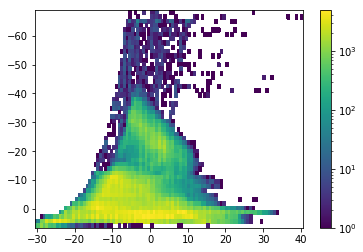

In [9]:
%%time
##############################################################################################################
# DO SOME HISTOGRAMS 
# This part hopefully is not too slow
##############################################################################################################
flat = high.Z10.values.flatten()
mask = np.isfinite(flat)
hst, xe, ye = np.histogram2d(flat[mask], high['T'].values.flatten()[mask], bins=(100,50))
norm = colors.LogNorm(vmin=np.nanmin(hst[np.nonzero(hst)]),
                      vmax=np.nanmax(hst))
plt.pcolormesh(xe, ye, hst.T, norm=norm)
plt.colorbar()
plt.gca().invert_yaxis()

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


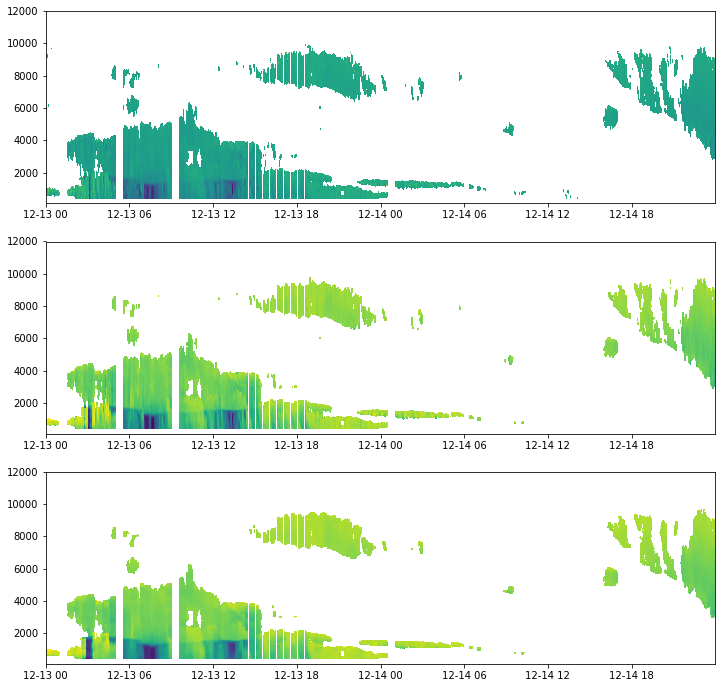

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].pcolormesh(tripex.time, tripex.range, tripex.V35)
axs[1].pcolormesh(tripex.time, tripex.range, tripex.V35m5)
axs[2].pcolormesh(tripex.time, tripex.range, tripex.V35m20)

In [11]:
tripex.V35.dims

('range', 'time')